Hypothesis: We might be representation bottlenecked and that might be contributing to our less than ideal performance. What if we start by pretraining our network to do autoencoding, chop off the decoder, and then do our metric learning on that

In [1]:
import transformer_lens
from datasets import load_dataset
import torch
import matplotlib.pyplot as plt
import pandas as pd
import torch.nn as nn
import numpy as np

import torch.nn.functional as F

from tqdm import tqdm

import random

In [2]:
seed = 42
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

In [3]:
# Load datasets
train_set = load_dataset("sentence-transformers/stsb", split="train")
val_set   = load_dataset("sentence-transformers/stsb", split="validation")
test_set  = load_dataset("sentence-transformers/stsb", split="test")

first_train  = torch.load('gpt2_medium_train_acts_1.npy')
second_train = torch.load('gpt2_medium_train_acts_2.npy')

first_test = torch.load('gpt2_medium_test_acts_1.npy')
second_test = torch.load('gpt2_medium_test_acts_2.npy')

generics_kb = torch.load('generics_kb_20k_10312024.npy')

train_scores = torch.Tensor(train_set['score'])
test_scores = torch.Tensor(test_set['score'])

  4%|██▊                                                                    | 10/250 [02:09<51:59, 13.00s/it]


Epoch 10
Train Losses - Early: 0.301, Mid: 1.289, Late: 10.822
Test Losses  - Early: 1.417, Mid: 5.092, Late: 26.179


  8%|█████▋                                                                 | 20/250 [04:20<49:52, 13.01s/it]


Epoch 20
Train Losses - Early: 0.249, Mid: 1.065, Late: 8.316
Test Losses  - Early: 1.315, Mid: 4.639, Late: 21.923


 12%|████████▌                                                              | 30/250 [06:31<47:59, 13.09s/it]


Epoch 30
Train Losses - Early: 0.220, Mid: 0.959, Late: 7.450
Test Losses  - Early: 1.274, Mid: 4.444, Late: 20.402


 16%|███████████▎                                                           | 40/250 [08:43<46:21, 13.25s/it]


Epoch 40
Train Losses - Early: 0.199, Mid: 0.888, Late: 6.928
Test Losses  - Early: 1.252, Mid: 4.341, Late: 19.845


 20%|██████████████▏                                                        | 50/250 [10:54<43:41, 13.11s/it]


Epoch 50
Train Losses - Early: 0.185, Mid: 0.834, Late: 6.564
Test Losses  - Early: 1.240, Mid: 4.303, Late: 19.632


 24%|█████████████████                                                      | 60/250 [13:07<42:25, 13.40s/it]


Epoch 60
Train Losses - Early: 0.175, Mid: 0.793, Late: 6.275
Test Losses  - Early: 1.239, Mid: 4.264, Late: 19.521


 28%|███████████████████▉                                                   | 70/250 [15:17<39:08, 13.05s/it]


Epoch 70
Train Losses - Early: 0.167, Mid: 0.761, Late: 6.050
Test Losses  - Early: 1.246, Mid: 4.224, Late: 19.387


 32%|██████████████████████▋                                                | 80/250 [17:27<36:59, 13.06s/it]


Epoch 80
Train Losses - Early: 0.160, Mid: 0.737, Late: 5.867
Test Losses  - Early: 1.246, Mid: 4.210, Late: 19.169


 36%|█████████████████████████▌                                             | 90/250 [19:40<34:57, 13.11s/it]


Epoch 90
Train Losses - Early: 0.155, Mid: 0.717, Late: 5.709
Test Losses  - Early: 1.257, Mid: 4.199, Late: 19.483


 40%|████████████████████████████                                          | 100/250 [21:50<32:12, 12.89s/it]


Epoch 100
Train Losses - Early: 0.151, Mid: 0.701, Late: 5.567
Test Losses  - Early: 1.262, Mid: 4.200, Late: 19.228


 44%|██████████████████████████████▊                                       | 110/250 [23:56<29:21, 12.58s/it]


Epoch 110
Train Losses - Early: 0.147, Mid: 0.687, Late: 5.450
Test Losses  - Early: 1.264, Mid: 4.169, Late: 19.229


 48%|█████████████████████████████████▌                                    | 120/250 [26:01<27:07, 12.52s/it]


Epoch 120
Train Losses - Early: 0.144, Mid: 0.675, Late: 5.343
Test Losses  - Early: 1.273, Mid: 4.165, Late: 19.110


 52%|████████████████████████████████████▍                                 | 130/250 [28:07<25:04, 12.53s/it]


Epoch 130
Train Losses - Early: 0.141, Mid: 0.665, Late: 5.245
Test Losses  - Early: 1.272, Mid: 4.168, Late: 19.221


 56%|███████████████████████████████████████▏                              | 140/250 [30:12<22:55, 12.50s/it]


Epoch 140
Train Losses - Early: 0.139, Mid: 0.656, Late: 5.161
Test Losses  - Early: 1.275, Mid: 4.152, Late: 19.316


 60%|██████████████████████████████████████████                            | 150/250 [32:17<20:54, 12.55s/it]


Epoch 150
Train Losses - Early: 0.136, Mid: 0.649, Late: 5.085
Test Losses  - Early: 1.285, Mid: 4.128, Late: 19.399


 64%|████████████████████████████████████████████▊                         | 160/250 [34:22<18:39, 12.43s/it]


Epoch 160
Train Losses - Early: 0.134, Mid: 0.642, Late: 5.016
Test Losses  - Early: 1.289, Mid: 4.096, Late: 19.125


 68%|███████████████████████████████████████████████▌                      | 170/250 [36:26<16:34, 12.44s/it]


Epoch 170
Train Losses - Early: 0.133, Mid: 0.637, Late: 4.954
Test Losses  - Early: 1.280, Mid: 4.103, Late: 19.240


 72%|██████████████████████████████████████████████████▍                   | 180/250 [38:30<14:28, 12.41s/it]


Epoch 180
Train Losses - Early: 0.131, Mid: 0.631, Late: 4.890
Test Losses  - Early: 1.292, Mid: 4.078, Late: 19.513


 76%|█████████████████████████████████████████████████████▏                | 190/250 [40:34<12:27, 12.46s/it]


Epoch 190
Train Losses - Early: 0.130, Mid: 0.626, Late: 4.846
Test Losses  - Early: 1.287, Mid: 4.096, Late: 19.320


 80%|████████████████████████████████████████████████████████              | 200/250 [42:37<10:17, 12.35s/it]


Epoch 200
Train Losses - Early: 0.129, Mid: 0.622, Late: 4.794
Test Losses  - Early: 1.288, Mid: 4.089, Late: 19.433


 84%|██████████████████████████████████████████████████████████▊           | 210/250 [44:41<08:15, 12.40s/it]


Epoch 210
Train Losses - Early: 0.127, Mid: 0.617, Late: 4.742
Test Losses  - Early: 1.286, Mid: 4.065, Late: 19.532


 88%|█████████████████████████████████████████████████████████████▌        | 220/250 [46:45<06:13, 12.44s/it]


Epoch 220
Train Losses - Early: 0.126, Mid: 0.614, Late: 4.703
Test Losses  - Early: 1.284, Mid: 4.064, Late: 19.630


 92%|████████████████████████████████████████████████████████████████▍     | 230/250 [48:49<04:07, 12.40s/it]


Epoch 230
Train Losses - Early: 0.125, Mid: 0.610, Late: 4.664
Test Losses  - Early: 1.286, Mid: 4.040, Late: 19.349


 96%|███████████████████████████████████████████████████████████████████▏  | 240/250 [50:52<02:03, 12.31s/it]


Epoch 240
Train Losses - Early: 0.124, Mid: 0.607, Late: 4.628
Test Losses  - Early: 1.288, Mid: 4.045, Late: 19.429


100%|██████████████████████████████████████████████████████████████████████| 250/250 [52:56<00:00, 12.71s/it]


Epoch 250
Train Losses - Early: 0.124, Mid: 0.603, Late: 4.589
Test Losses  - Early: 1.287, Mid: 4.024, Late: 19.705


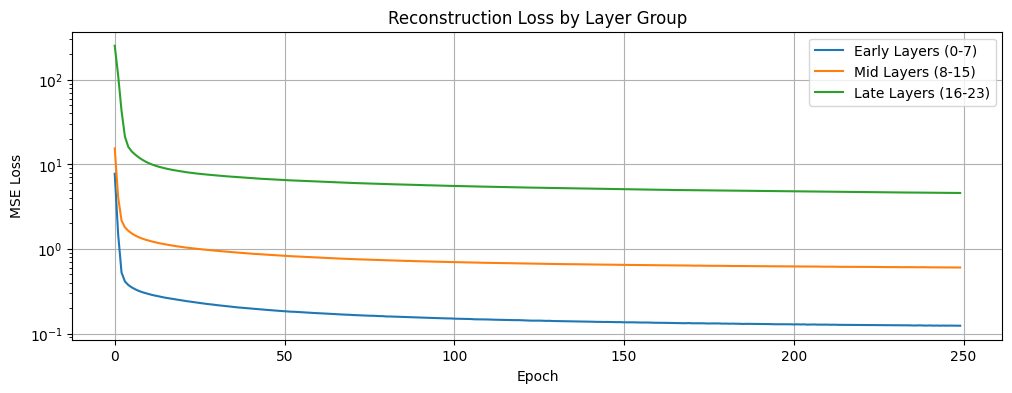

In [4]:
# We probably need to scale the hidden dimension based on how deep you are
def get_hidden(i):
    if i < 12:
        return 1
    else:
        return 2

class Autoencoder(nn.Module):
    def __init__(self, layer_idx, d_in=1024, base_width=256, dropout_rate=0.1):
        super().__init__()
        # Scale hidden dim based on layer position
        # Later layers get progressively larger capacity
        hidden_mult = get_hidden(layer_idx)
        d_hidden = int(base_width * hidden_mult)
        
        # Gradual dimension reduction
        d_mid = (d_in + d_hidden) // 2
        
        self.encode = nn.Sequential(
            nn.Linear(d_in, d_mid),
            nn.LayerNorm(d_mid),
            nn.Dropout(dropout_rate),  # After normalization, before activation
            nn.GELU(),
            nn.Linear(d_mid, d_hidden),
            nn.LayerNorm(d_hidden),
            nn.Dropout(dropout_rate),  # After normalization, before activation
            nn.GELU(),
        )
        
        self.decode = nn.Sequential(
            nn.Linear(d_hidden, d_mid),
            nn.LayerNorm(d_mid),
            nn.Dropout(dropout_rate),  # After normalization, before activation
            nn.GELU(),
            nn.Linear(d_mid, d_in),
            # No dropout before final output layer
        )
        
        # Initialize with smaller weights for stability
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight, gain=0.5)
                
    def forward(self, x):
        h = self.encode(x)
        return self.decode(h)

n_layers = 24
# Create layer-specific autoencoders
encoders = [Autoencoder(i).cuda() for i in range(n_layers)]

# Use different learning rates for different layers
lrs = [3e-4 * (1 + i/24) for i in range(n_layers)]  # Higher lr for harder layers. From 3e-4 -> 3e-4*3
optimizers = [torch.optim.AdamW(ae.parameters(), lr=lr, weight_decay=0.01) for ae, lr in zip(encoders, lrs)]

# Modified training loop with layer-specific logging
def train_epoch(models, acts, optimizers, batch_size=64):
    indices = torch.randperm(acts.shape[0])
    shuffled_acts = acts[indices]
    
    losses = []
    n_batches = shuffled_acts.shape[0] // batch_size
    
    for batch in range(n_batches):
        start_idx = batch * batch_size
        end_idx = (batch + 1) * batch_size
        
        batch_losses = []
        for i, (model, optimizer) in enumerate(zip(models, optimizers)):
            model.train()
            batch_i = shuffled_acts[start_idx:end_idx, i].cuda()
            
            optimizer.zero_grad()
            loss = F.mse_loss(model(batch_i), batch_i)
            loss.backward()
            optimizer.step()
            
            batch_losses.append(loss.item())
        
        losses.append(batch_losses)
    
    return np.mean(losses, axis=0)

# Training with more detailed monitoring
early_layers_history = []
mid_layers_history = []
late_layers_history = []

all_acts = generics_kb
all_test_acts = torch.concat((first_test, second_test), axis=0)

for epoch in tqdm(range(250)):
    losses = train_epoch(encoders, all_acts, optimizers)
    
    # Track different layer groups
    early_layers_history.append(np.mean(losses[:8]))
    mid_layers_history.append(np.mean(losses[8:16]))
    late_layers_history.append(np.mean(losses[16:]))
    
    if (epoch+1) % 10 == 0:
        with torch.no_grad():
            [model.eval() for model in encoders]
            
            # Test losses by layer group
            test_preds = [encoders[i](all_test_acts[:, i].cuda()).cpu() for i in range(n_layers)]
            test_losses = [F.mse_loss(pred, all_test_acts[:, i]).item() for i, pred in enumerate(test_preds)]
            
            print(f"\nEpoch {epoch+1}")
            print(f"Train Losses - Early: {early_layers_history[-1]:.3f}, "
                  f"Mid: {mid_layers_history[-1]:.3f}, "
                  f"Late: {late_layers_history[-1]:.3f}")
            print(f"Test Losses  - Early: {np.mean(test_losses[:8]):.3f}, "
                  f"Mid: {np.mean(test_losses[8:16]):.3f}, "
                  f"Late: {np.mean(test_losses[16:]):.3f}")

# Plot training curves
plt.figure(figsize=(12, 4))
plt.plot(early_layers_history, label='Early Layers (0-7)')
plt.plot(mid_layers_history, label='Mid Layers (8-15)')
plt.plot(late_layers_history, label='Late Layers (16-23)')
plt.title('Reconstruction Loss by Layer Group')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.yscale('log')
plt.grid(True)
plt.show()

In [5]:
class SiameseNetwork(nn.Module):
    def __init__(self, mlp):
        super().__init__()
        self.mlp = mlp

    def forward(self, x1, x2):
        h1 = self.mlp(x1)
        h2 = self.mlp(x2)
        return F.cosine_similarity(h1, h2, dim=-1)

class LayerwiseSiameseNetworks(nn.Module):
    def __init__(self, encoders, n_layers=24, d_in=1024, d_hidden=256):
        super().__init__()
        self.n_layers = n_layers
        self.layer_nets = nn.ModuleList([SiameseNetwork(encoders[i]) for i in range(n_layers)])

    def forward(self, x1, x2):
        similarities = []
        for layer in range(self.n_layers):
            net_at_layer = self.layer_nets[layer].cuda()
            # Get the activations at the given layer
            x1_l = x1[:, layer].cuda()
            x2_l = x2[:, layer].cuda()

            sim_at_layer = net_at_layer(x1_l, x2_l)
            # print(sim_at_layer.shape)
            similarities.append(sim_at_layer)

        return torch.stack(similarities, dim=-1)

class SimilarityLearner(nn.Module):
    def __init__(self, encoders, n_layers=24, d_in=1024, d_hidden=256, d_out_hidden=512, dropout=0.1):
        super().__init__()
        self.layer_nets = LayerwiseSiameseNetworks(encoders, n_layers, d_in, d_hidden)

        self.mlp = nn.Sequential(
            nn.Linear(n_layers, d_out_hidden),
            nn.LayerNorm(d_out_hidden),
            nn.Dropout(dropout),  # Add dropout after normalization
            nn.GELU(),
            nn.Linear(d_out_hidden, d_out_hidden),
            nn.LayerNorm(d_out_hidden),
            nn.Dropout(dropout),  # Add dropout after normalization
            nn.GELU(),
            nn.Linear(d_out_hidden, d_out_hidden),
            nn.LayerNorm(d_out_hidden),
            nn.Dropout(dropout),  # Add dropout after normalization
            nn.GELU(),
            nn.Linear(d_out_hidden, 1),
            nn.Hardsigmoid()
        )

    def forward(self, x1, x2, training=True):
        layerwise_similarities = self.layer_nets(x1, x2)
        similarity = self.mlp(layerwise_similarities)
        return similarity.squeeze()

In [6]:
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

from copy import deepcopy
cloned_encoders = [deepcopy(e).encode for e in encoders]

similarity_learner = SimilarityLearner(cloned_encoders, d_hidden=512).to('cuda:0')
optimizer = torch.optim.Adam(similarity_learner.parameters(), lr=3e-4)

def train_epoch(model, first_acts, second_acts, scores, optimizer, batch_size=128):
    indices = torch.randperm(first_acts.shape[0])
    shuffled_first = first_acts[indices]
    shuffled_second = second_acts[indices]
    shuffled_scores = scores[indices]

    model.train()
    total_loss = 0
    n_batches = first_acts.shape[0] // batch_size
    
    for batch in range(n_batches):
        start_idx = batch * batch_size
        end_idx = (batch + 1) * batch_size
        
        x1_batch = shuffled_first[start_idx:end_idx].cuda()
        x2_batch = shuffled_second[start_idx:end_idx].cuda()
        scores_batch = shuffled_scores[start_idx:end_idx].cuda()
        
        optimizer.zero_grad()
        
        sims = model(x1_batch, x2_batch)

        resids = sims - scores_batch
        loss = torch.log((sims - scores_batch).var())
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    return total_loss / n_batches

best_test_corr = 0
best_model = None

for epoch in tqdm(range(150)):
    # Training
    # loss = train_epoch(similarity_learner, first_train_fake, second_train_fake, train_scores_fake, optimizer)
    loss = train_epoch(similarity_learner, first_train, second_train, train_scores, optimizer)
    
    # Evaluation
    similarity_learner.eval()
    with torch.no_grad():
        # Print progress every 10 epochs
        if (epoch + 1) % 10 == 0:
            # Get training correlations
            train_preds = similarity_learner(first_train.cuda(), second_train.cuda(), training=False)
            train_corr = torch.corrcoef(torch.stack([train_preds.cpu(), train_scores]))[0,1]
            
            # Get test correlations
            test_preds = similarity_learner(first_test.cuda(), second_test.cuda(), training=False)
            test_corr = torch.corrcoef(torch.stack([test_preds.cpu(), test_scores]))[0,1]

            if test_corr > best_test_corr:
                best_test_corr = test_corr
                best_model = deepcopy(similarity_learner)

            print(f"Epoch {epoch+1}")
            print(f"Loss: {loss:.10f}")
            print(f"Train correlation: {train_corr*100:.3f}")
            print(f"Test correlation: {test_corr*100:.3f}\n")

  7%|████▋                                                                  | 10/150 [00:18<04:21,  1.87s/it]

Epoch 10
Loss: -4.5077521638
Train correlation: 94.924
Test correlation: 73.504



 13%|█████████▍                                                             | 20/150 [00:38<04:20,  2.01s/it]

Epoch 20
Loss: -5.2842579755
Train correlation: 97.704
Test correlation: 75.241



 20%|██████████████▏                                                        | 30/150 [00:57<04:00,  2.01s/it]

Epoch 30
Loss: -5.7758141648
Train correlation: 98.609
Test correlation: 76.025



 27%|██████████████████▉                                                    | 40/150 [01:16<03:39,  2.00s/it]

Epoch 40
Loss: -6.0619459152
Train correlation: 98.667
Test correlation: 76.410



 33%|███████████████████████▋                                               | 50/150 [01:36<03:20,  2.01s/it]

Epoch 50
Loss: -6.2665145072
Train correlation: 98.908
Test correlation: 76.170



 40%|████████████████████████████▍                                          | 60/150 [01:56<02:59,  2.00s/it]

Epoch 60
Loss: -6.5109481161
Train correlation: 98.882
Test correlation: 76.488



 47%|█████████████████████████████████▏                                     | 70/150 [02:15<02:42,  2.03s/it]

Epoch 70
Loss: -6.6273105795
Train correlation: 99.381
Test correlation: 76.816



 53%|█████████████████████████████████████▊                                 | 80/150 [02:35<02:21,  2.02s/it]

Epoch 80
Loss: -6.8305018707
Train correlation: 99.099
Test correlation: 76.309



 60%|██████████████████████████████████████████▌                            | 90/150 [02:55<02:01,  2.02s/it]

Epoch 90
Loss: -7.0095370574
Train correlation: 99.191
Test correlation: 76.511



 67%|██████████████████████████████████████████████▋                       | 100/150 [03:14<01:39,  2.00s/it]

Epoch 100
Loss: -7.0299088305
Train correlation: 99.326
Test correlation: 76.863



 73%|███████████████████████████████████████████████████▎                  | 110/150 [03:33<01:20,  2.00s/it]

Epoch 110
Loss: -7.1466183337
Train correlation: 99.449
Test correlation: 76.682



 80%|████████████████████████████████████████████████████████              | 120/150 [03:53<01:00,  2.02s/it]

Epoch 120
Loss: -7.2881236618
Train correlation: 99.437
Test correlation: 76.212



 87%|████████████████████████████████████████████████████████████▋         | 130/150 [04:13<00:40,  2.02s/it]

Epoch 130
Loss: -7.2909176458
Train correlation: 99.367
Test correlation: 76.086



 93%|█████████████████████████████████████████████████████████████████▎    | 140/150 [04:33<00:20,  2.03s/it]

Epoch 140
Loss: -7.4097536260
Train correlation: 99.282
Test correlation: 76.098



100%|██████████████████████████████████████████████████████████████████████| 150/150 [04:52<00:00,  1.95s/it]

Epoch 150
Loss: -7.4662285935
Train correlation: 99.601
Test correlation: 76.001



In [7]:
param_count = sum([w.numel() for w in similarity_learner.parameters()])
f"This model has {param_count} parameters!"

'This model has 24606209 parameters!'

In [8]:
test_preds = best_model(first_test.cuda(), second_test.cuda(), training=False)
test_corr = torch.corrcoef(torch.stack([test_preds.cpu(), test_scores]))[0,1]
print(test_corr)

from scipy.stats import spearmanr
print(spearmanr(test_preds.detach().cpu(), test_scores))

tensor(0.7686, grad_fn=<SelectBackward0>)
SignificanceResult(statistic=0.7530396159538115, pvalue=1.3484450421664223e-252)


## Residual histogram and qq plot

In [9]:
residuals = (test_preds.cpu().detach().numpy() - test_scores.numpy())
residuals.mean(), residuals.std()

(0.061434872, 0.19719057)

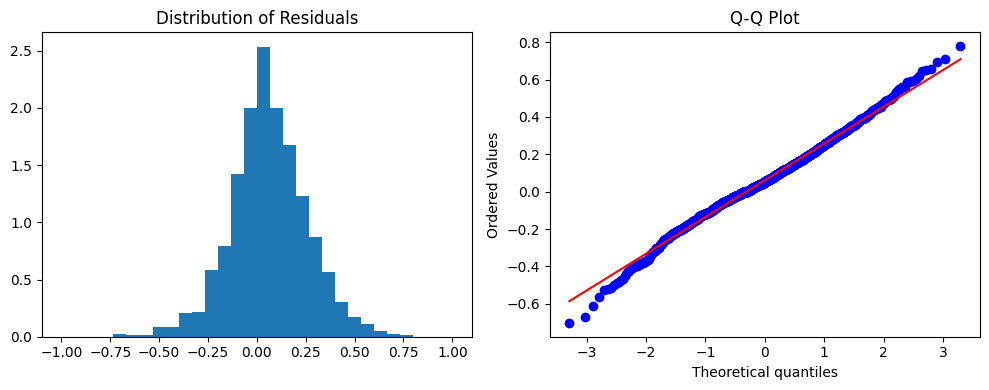

ShapiroResult(statistic=0.9940272538881987, pvalue=2.4393299409365893e-05)


In [10]:
import matplotlib.pyplot as plt
import scipy.stats as stats

def plot_qq(residuals):
   fig = plt.figure(figsize=(10, 4))
   
   # Left plot: Histogram of residuals
   plt.subplot(121)
   plt.hist(residuals, bins=30, density=True, range=[-1,1])
   plt.title('Distribution of Residuals')
   
   # Right plot: Q-Q plot
   plt.subplot(122)
   stats.probplot(residuals, dist="norm", plot=plt)
   plt.title('Q-Q Plot')
   
   plt.tight_layout()
   plt.show()

# Usage:
plot_qq(residuals)
print(stats.shapiro(residuals))

The Shapiro-Wilk test results (p < 0.05) lead us to reject the null hypothesis of normality, indicating evidence of departure from a normal distribution

In [11]:
worst_overdone = np.absolute(residuals).argsort()[-25:]

In [12]:
list(zip(test_set.select(worst_overdone)['sentence1'], test_set.select(worst_overdone)['sentence2'], test_scores[worst_overdone], test_preds[worst_overdone]))

[('MIER ups 2012 growth forecast to 4.2pc',
  'CMIE cuts 2012-13 growth forecast to 6.3%',
  tensor(0.1600),
  tensor(0.6819, device='cuda:0', grad_fn=<UnbindBackward0>)),
 ('A brown dog is jumping.',
  'A brown dog is jumping',
  tensor(1.),
  tensor(0.4735, device='cuda:0', grad_fn=<UnbindBackward0>)),
 ('You just have to base your answer on what you do know, which is what you want.',
  'You may want it, but the process given to you is what you have to work within.',
  tensor(0.),
  tensor(0.5331, device='cuda:0', grad_fn=<UnbindBackward0>)),
 ('Yes, there is a reason for it.',
  'Yes, that is exactly what it means.',
  tensor(0.2000),
  tensor(0.7440, device='cuda:0', grad_fn=<UnbindBackward0>)),
 ('Some of what you can do:',
  'Not much you can do besides:',
  tensor(0.2000),
  tensor(0.7522, device='cuda:0', grad_fn=<UnbindBackward0>)),
 ('Romney Wins Nevada Caucus',
  'Romney shifts focus to Santorum ahead caucuses',
  tensor(0.2000),
  tensor(0.7522, device='cuda:0', grad_fn=<Un